In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from typing import Optional
import torchvision
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from icecream import ic
from cop_diffusion.utils import save_model, load_model


device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
device

device(type='mps')

In [82]:
def load_fashion_mnist():
    train = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )
    val = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )
    return train, val

In [83]:
train_ds, val_ds = load_fashion_mnist()

In [86]:
def load_cifar():
    train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    val = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )
    return train, val


def data_loaders(train_data, val_data, batch_size):
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    return train_loader, val_loader


training_data, validation_data = load_cifar()
# training_data, validation_data = load_fashion_mnist()
training_loader, validation_loader = data_loaders(
    training_data, validation_data, batch_size=10
)
x_train_var = np.var(training_data.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
training_data.data.min(), training_data.data.max()

(0, 255)

In [88]:
def display_image_grid(x, title: str = "") -> None:
    x = make_grid(x.cpu().detach() + 0.5)
    x = x.numpy()
    ic(x.shape)
    ic(np.transpose(x, (1, 2, 0)).shape)
    fig = plt.imshow(np.transpose(x, (1, 2, 0)), interpolation="nearest")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [89]:
def show_image(x, one_channel=False, title: Optional[str] = None):
    img_grid = make_grid(x.cpu())
    img = img_grid.permute(1, 2, 0)
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    if title:
        axs.set_title(title)
    if one_channel:
        axs.imshow(img, cmap="Greys")
    else:
        axs.imshow(img)
    axs.axis("off")

ic| x.shape: torch.Size([10, 3, 32, 32])


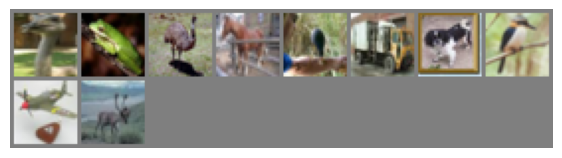

In [96]:
x, _ = next(iter(training_loader))
x = x.to(device)
ic(x.shape)
show_image(x)

# Resnet like layers

In [97]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_dim, res_h_dim, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1, stride=1, bias=False),
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)] * n_res_layers
        )

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.45585614..1.0145967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..3.469932].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..3.5029814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..6.458312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..62.20798].


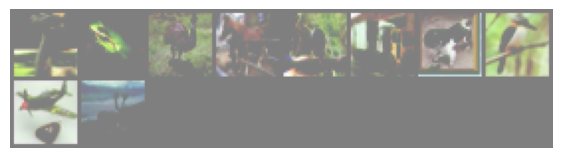

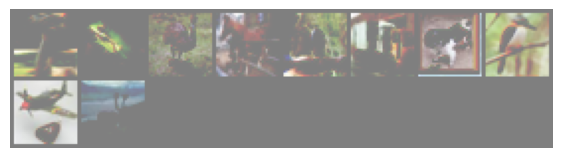

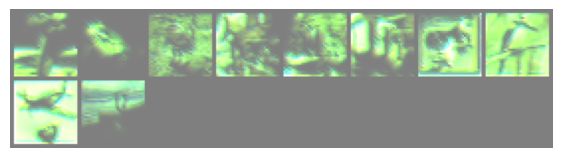

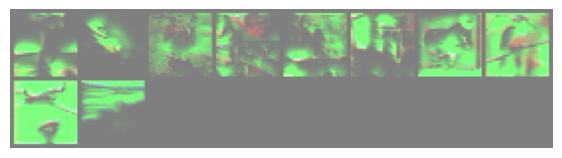

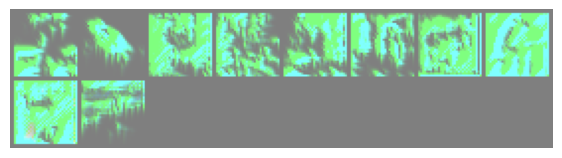

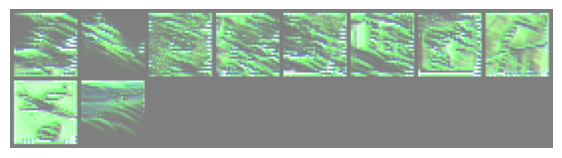

In [98]:
# random data
# x = np.random.random_sample((3, 40, 40, 200))
# x = torch.tensor(x).float()
# test Residual Layer
res = ResidualLayer(3, 3, 3).to(device)
res_out = res(x)
show_image(res_out)


# test res stack
for i in sorted(random.sample(list(range(1, 101)), 5)):
    res_stack = ResidualStack(3, 3, 3, i).to(device)
    res_stack_out = res_stack(x)
    # ic(res_stack_out.shape)
    show_image(res_stack_out)

## VQ-VAE
Operates on the whole image:
1.	Encoder: The encoder processes the entire image and converts it into a continuous latent representation.
2.	Quantization: This continuous latent representation is then mapped to a finite set of discrete latent vectors (the codebook).
3.	Decoder: The discrete latent vectors are then decoded back into the image.
    

In [99]:
class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(
                h_dim, h_dim, kernel_size=kernel - 1, stride=stride - 1, padding=1
            ),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
        )

    def forward(self, x):
        return self.conv_stack(x)

ic| x.shape: torch.Size([10, 3, 32, 32])
ic| encoder_out.shape: torch.Size([10, 3, 8, 8])


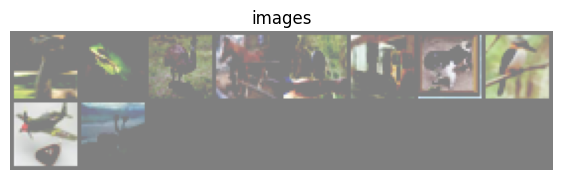

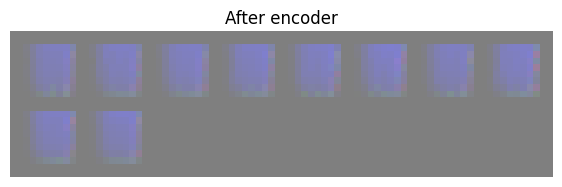

In [135]:
# random data
# x = np.random.random_sample((3, 40, 40, 200))
# x = torch.tensor(x).float()

# test encoder
encoder = Encoder(in_dim=3, h_dim=3, n_res_layers=20, res_h_dim=10).to(device)
encoder_out = encoder(x)
ic(x.shape)
ic(encoder_out.shape)
# print("Encoder out shape:", encoder_out.shape)
show_image(x, title="images")
show_image(encoder_out, title="After encoder")

## Vector Quantizer

- (before) Encoder maps x -> z_e (latent space)

- Quantizer: Map continuous latent representation (as encoded) to a discrete one. 
It quantizes the latent vectors to the nearest vector in the codebook (embedding vocabulary), aka transform the encoder output into a discrete one-hot vector that is the index of the closest embedding vector z_e -> z_q

  - A distance between z (encoded) and each embedding is computed: $$e_j (z - e)^2 = z^2 + e^2 - 2 e * z$$

- (after) Decoder maps z_q -> x_hat to reconstruct the original image.

In [106]:
vocab_size = 30
ic(vocab_size)
emb_dim = 10
ic(emb_dim)
emb = nn.Embedding(vocab_size, emb_dim).to(device)
emb.weight.data.uniform_(
    -1.0 / vocab_size,
    1.0 / vocab_size,
)
ic(emb.weight.shape)
# create a encoded z of emb_dim.

enc = Encoder(in_dim=3, h_dim=emb_dim, n_res_layers=1, res_h_dim=3).to(device)
z = enc(x)
ic(z.shape)
# reshape z -> (batch, height, width, channel) and flatten
z = z.permute(0, 2, 3, 1).contiguous()
ic(z.shape, "after permutation")
z_flattened = z.view(-1, emb_dim)
ic(z_flattened.shape);

ic| vocab_size: 30
ic| emb_dim: 10
ic| emb.weight.shape: torch.Size([30, 10])
ic| z.shape: torch.Size([10, 10, 8, 8])
ic| z.shape: torch.Size([10, 8, 8, 10]), 'after permutation'
ic| z_flattened.shape: torch.Size([640, 10])


In [133]:
# compute distance to each embedding for each flattened item, so it can take the closest one.
dist = (
    torch.sum(z_flattened**2, dim=1, keepdim=True)
    + torch.sum(emb.weight**2, dim=1)
    - 2 * torch.matmul(z_flattened, emb.weight.t())
)
ic(dist.shape, "dist shape is z[0].shape, vocab_size")
assert dist.shape[1] == vocab_size

# find the index of the closest one.
min_encoding_indices = torch.argmin(dist, dim=1).to(device).unsqueeze(1)
ic(min_encoding_indices.shape)
min_encodings = torch.zeros(min_encoding_indices.shape[0], vocab_size).to(device)
min_encodings = F.one_hot(min_encoding_indices, num_classes=vocab_size)
ic(min_encodings.shape, "one hot encoded per vocabulary entry")
# get quantized latent vectors
# z_q = torch.matmul(min_encodings, emb.weight).view(z.shape)
# emb(min_encoding_indices)
ic(min_encoding_indices[0].item())
ic(min_encodings[0])
ic(min_encodings[0][0][min_encoding_indices[0]]);  # the one hot encoded indice

ic| dist.shape: torch.Size([640, 30])
    "dist shape is z[0].shape, vocab_size": 'dist shape is z[0].shape, vocab_size'
ic| min_encoding_indices.shape: torch.Size([640, 1])
ic| min_encodings.shape: torch.Size([640, 1, 30])
    "one hot encoded per vocabulary entry": 'one hot encoded per vocabulary entry'
ic| min_encoding_indices[0].item(): 17
ic| min_encodings[0]: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                               0, 0, 0, 0, 0, 0]], device='mps:0')
ic| min_encodings[0][0][min_encoding_indices[0]]: tensor([1], device='mps:0')


In [131]:
emb(torch.tensor([0, 1, 3]).to(device))
emb(min_encoding_indices).shape

torch.Size([640, 1, 10])

In [132]:
min_encoding_indices[0].item()

17

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, vocab_size, emb_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.vocab_size, self.emb_dim)
        self.embedding.weight.data.uniform_(
            -1.0 / self.vocab_size, 1.0 / self.vocab_size
        )

    def get_device(self):
        return next(self.parameters()).device

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.emb_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = (
            torch.sum(z_flattened**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(z_flattened, self.embedding.weight.t())
        )

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        # min_encodings = torch.zeros(min_encoding_indices.shape[0], self.n_e).to(device)
        # min_encodings.scatter_(1, min_encoding_indices, 1)
        # get quantized latent vectors
        # z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        z_q = self.embedding(min_encoding_indices)
        z_q = z_q.view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach() - z) ** 2) + self.beta * torch.mean(
            (z_q - z.detach()) ** 2
        )

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        oh_encodings = F.one_hot(
            min_encoding_indices, num_classes=self.vocab_size
        ).float()
        e_mean = torch.mean(oh_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, oh_encodings, min_encoding_indices

In [ ]:
enc = Encoder(in_dim=3, h_dim=emb_dim, n_res_layers=1, res_h_dim=3).to(device)
z = enc(x)
vq = VectorQuantizer(vocab_size=vocab_size, emb_dim=emb_dim, beta=0.25).to(device)
vq(z)

## Decodes latent discrete representation to an image.

In [ ]:
class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel - 1, stride=stride - 1, padding=1
            ),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(
                h_dim, h_dim // 2, kernel_size=kernel, stride=stride, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                h_dim // 2, 3, kernel_size=kernel, stride=stride, padding=1
            ),
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

In [ ]:
# random data
# x = np.random.random_sample((3, 40, 40, 200))
# x = torch.tensor(x).float()

# test decoder
decoder = Decoder(in_dim=3, h_dim=3, n_res_layers=10, res_h_dim=15).to(device)
decoder_out = decoder(encoder_out)
print("Dncoder out shape:", decoder_out.shape)
ic(decoder_out.shape)
show_image(decoder_out, "Decoded image")

In [ ]:
class VQVAE(nn.Module):
    def __init__(
        self,
        h_dim,
        res_h_dim,
        n_res_layers,
        n_embeddings,
        embedding_dim,
        beta,
        save_img_embedding_map=False,
    ):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1
        )
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):
        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print("original data shape:", x.shape)
            print("encoded data shape:", z_e.shape)
            print("recon data shape:", x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity

In [ ]:
batch_size = 32
n_updates = 5000
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 512
beta = 0.25
learning_rate = 3e-4
log_interval = 100
dataset = "CIFAR10"

model_version = "0.1.1"
model_name = "vqvae"

model = VQVAE(
    n_hiddens, n_residual_hiddens, n_residual_layers, n_embeddings, embedding_dim, beta
).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
model.train()
training_loader, validation_loader = data_loaders(
    training_data, validation_data, batch_size=batch_size
)
x_train_var = np.var(training_data.data / 255.0)
ic(x_train_var)

In [ ]:
from datetime import datetime


results = {
    "n_updates": 0,
    "recon_errors": [],
    "loss_train": [],
    "perplexities": [],
}
save: bool = True
n_updates = 1001
last_update = 0
if last_update > 0:
    model = load_model(
        model_name=model_name, model_version=model_version, iter=last_update
    )
    from_update_nb = last_update + 1
else:
    from_update_nb = 0

do_train: bool = True
if do_train:
    writer = SummaryWriter(
        f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
    )
    ex_x, ex_y = next(iter(training_loader))
    writer.add_graph(model, (ex_x.to(device)), use_strict_trace=False)
    writer.flush()

    split = "train"
    with tqdm(
        total=n_updates - from_update_nb,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        for i in range(from_update_nb, n_updates):
            (x, _) = next(iter(training_loader))

            x = x.to(device)
            optimizer.zero_grad()

            embedding_loss, x_hat, perplexity = model(x)
            recon_loss = torch.mean((x_hat - x) ** 2) / x_train_var
            loss = recon_loss + embedding_loss

            loss.backward()
            optimizer.step()

            results["recon_errors"].append(recon_loss.cpu().detach().numpy())
            results["perplexities"].append(perplexity.cpu().detach().numpy())
            results["loss_train"].append(loss.cpu().detach().numpy())
            results["n_updates"] = i

            pbar.update(1)
            pbar.set_postfix(
                {"update_nb": i, "train_loss": f"{results['loss_train'][-1]:.4f}"}
            )

            if i % log_interval == 0:
                for name, kernel_weight in model.named_parameters():
                    writer.add_histogram(name, kernel_weight, i)

                inter_recon_errors = np.mean(results["recon_errors"][-log_interval:])
                inter_loss = np.mean(results["loss_train"][-log_interval:])
                inter_perplexity = np.mean(results["perplexities"][-log_interval:])

                writer.add_scalar(f"{split} loss", inter_loss, i)
                writer.add_scalar(f"{split} recon_errors", inter_recon_errors, i)
                writer.add_scalar(f"{split} perplexity", inter_perplexity, i)
    if save:
        save_model(
            model=model, model_name=model_name, model_version=model_version, iter=i
        )
else:
    model = load_model(
        model_name=model_name, model_version=model_version, iter=last_update
    )

In [ ]:
x, _ = next(iter(training_loader))
display_image_grid(x)

In [ ]:
def reconstruct(data_loader, model):
    (x, _) = next(iter(data_loader))
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _, e_indices = model.vector_quantization(vq_encoder_output)

    x_recon = model.decoder(z_q)
    return x, x_recon, z_q, e_indices

In [ ]:
x_val, x_val_recon, z_q, e_indices = reconstruct(validation_loader, model)
print(x_val.shape)
display_image_grid(x_val)

In [ ]:
display_image_grid(x_val_recon)